# Computing second- and third-order shear statistics on a full-sky mock catalog

In this notebooks we compute second- and third-order shear correlation functions on a realistic full-sky shape catalog. <br><br>
**Warning:** This notebook requires significant memory (~40GB) and CPU (~15h) resources!

In [1]:
from astropy.table import Table
import numpy as np
import time
import sys
import healpy as hp
from matplotlib import pyplot as plt

import orpheus

## Prepare a mock Catalog

At first let us define a few paramaters that we use for creating the mock

### Define ra/dec position on a simple mask

This is a helper function that generates a simplistic full-sky mock given a mask consisting of a large-scale footprint and some smaller cut-out circles. For the purpuse of this notebook positions are sufficient such that we do not include any tracers.

In [2]:
def gen_mock(nbar_arcmin2, nside_hp, rseed, nside_mask, nmask, r_mean, r_std):

    # Sample random points
    npoints = int(41_252.96*3600*nbar_arcmin2)
    np.random.seed(rseed)
    rand_ra = np.random.uniform(0, 2*np.pi, npoints)
    rand_sindec = np.random.uniform(np.sin(-np.pi/2), np.sin(np.pi/2), npoints)
    rand_dec = np.arcsin(rand_sindec)

    # Large scale footprint
    bigmask = np.ones(npoints, dtype=bool)
    bigmask *= rand_ra < 2*np.pi/3
    bigmask *= ((rand_ra + 2*rand_dec) < .7*np.pi)
    bigmask *= ~(((rand_ra-.4*rand_dec) > 70*np.pi/180) * ((rand_ra-.4*rand_dec) < 80*np.pi/180))

    # Smaller cutouts
    rrad = np.abs(np.random.normal(loc=r_mean,scale=r_std,size=nmask))
    rind = np.random.randint(hp.nside2npix(nside_mask),size=nmask)
    smallmask = set({})
    for imask in range(nmask):
        nextmask = hp.query_disc(nside=nside_mask, vec=hp.pix2vec(ipix=rind[imask],nside=nside_mask), radius=rrad[imask]*np.pi/180.)
        smallmask = smallmask.union(nextmask)
    smallmask = list(smallmask)
    smallmask_map = np.ones(hp.nside2npix(nside_mask))
    smallmask_map[smallmask] = 0

    # Map the angular positions on healpix grid and check which ones lie in masked regions
    hpinds_maskmap, hpinds_onmask = orpheus.cat2hpx(lon= rand_ra[bigmask]*180./np.pi, lat=rand_dec[bigmask]*180./np.pi, nside=nside_mask, return_indices=True)
    unmasked = (hpinds_onmask*smallmask_map[hpinds_onmask]).astype(bool)
    # Retrieve healpix indices and map for the same resolution as for the T17 map
    ra_unmasked = rand_ra[bigmask][unmasked]*180./np.pi
    dec_unmasked = rand_dec[bigmask][unmasked]*180./np.pi
    hpinds_map, hpinds_data = orpheus.cat2hpx(lon=ra_unmasked, lat=dec_unmasked, nside=nside_hp, return_indices=True)

    return ra_unmasked, dec_unmasked, hpinds_map, hpinds_data

In [3]:
nbar_arcmin2 = 0.5 # Number density of tracers in the mock
nside_hp = 8192 # Angular resolution of map of tracers
rseed = 42 # Random seed used in the initialization of the random points and the mask
nside_mask = 512 # Nside used for the creation of the mask
nmask = 10_000 # Number of circle-shaped holes in the fullsky
r_mean = 0.5 # Mean radius of a hole in degrees
r_std = 0.2 # Std of the radius of a hole in degrees

In [4]:
ra_unmasked, dec_unmasked, hpinds_map, hpinds_data = gen_mock(nbar_arcmin2=nbar_arcmin2,
                                                              nside_hp=nside_hp,
                                                              rseed=rseed,
                                                              nside_mask=nside_mask,
                                                              nmask=nmask, 
                                                              r_mean=r_mean, 
                                                              r_std=r_std)

### Add realistic shear signal from T17 simulations

First, let us download and read in a mock convergence map from the Takahasi simulation suite. This is a single lensplane located at $z\approx1$.

In [5]:
catname = "allskymap_nres13r000.zs16.mag.dat"
path_to_T17 = "http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/sub1/nres13/" + catname
savepath_T17 = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/Takahashi/DES_Y3/data/tmpdata/"

In [ ]:
!wget {path_to_T17} -P {savepath_T17}

In [6]:
# This script is shamelessly copied from the T17 website (http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/read.py)
skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]

with open(savepath_T17+catname, 'rb') as f:
    rec = np.fromfile(f, dtype='uint32', count=1)[0]
    nside = np.fromfile(f, dtype='int32', count=1)[0]
    npix = np.fromfile(f, dtype='int64', count=1)[0]
    rec = np.fromfile(f, dtype='uint32', count=1)[0]
    print("nside:{} npix:{}".format(nside, npix))

    rec = np.fromfile(f, dtype='uint32', count=1)[0]

    print('kappa')
    kappa = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        kappa = np.append(kappa, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            kappa = np.append(kappa, load)

    print('gamma1')
    gamma1 = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        gamma1 = np.append(gamma1, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            gamma1 = np.append(gamma1, load)

    print('gamma2')
    gamma2 = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        gamma2 = np.append(gamma2, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            gamma2 = np.append(gamma2, load)

nside:8192 npix:805306368
kappa
gamma1
gamma2


### Finalize catalog
Let us now finalize the catalog by retrieveng the WL quantities at the positions of the galaxies.

In [7]:
fskycat = {}
fskycat['ra'] = ra_unmasked
fskycat['dec'] = dec_unmasked
fskycat['kappa'] = kappa[hpinds_data]
fskycat['gamma1'] = gamma1[hpinds_data]
fskycat['gamma2'] = gamma2[hpinds_data]

Let us now have a quick view of the retrieved mask.

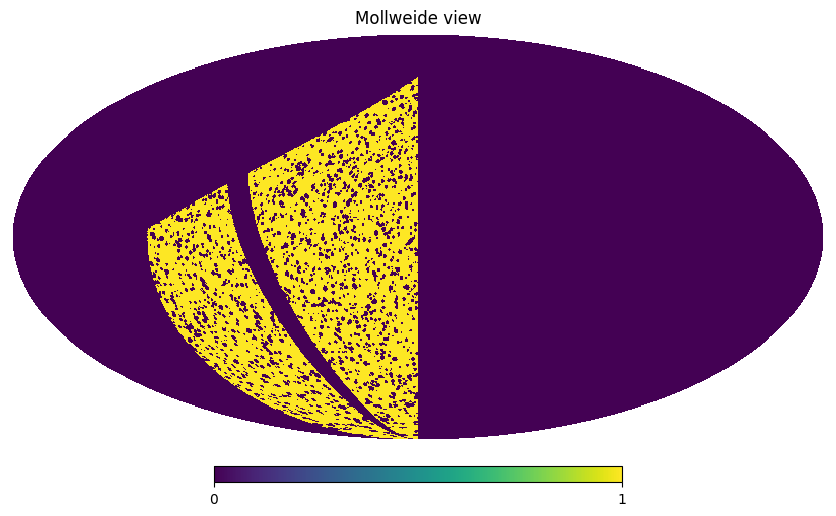

In [8]:
hpinds_fullmaskmap, _ = orpheus.cat2hpx(lon=fskycat['ra'], lat=fskycat['dec'], nside=nside_mask, return_indices=True)
hp.mollview(hpinds_fullmaskmap)
plt.show()

## Do 2PCF computation on orpheus

### Initialise relevant classes

In [9]:
# General setup for 2pcf computation
min_sep = 0.25
max_sep = 240.
binsize = 0.1
rmin_pixsize = 20
tree_resos=[0,1.,2.,4.]
nthreads = 48

# Parametes we use for the decomposition of the catalog into patches
npatches = 100
patchextend_deg=4.

When intialising the `orpheus.SpinTracerCatalog` instance, it is important to specify the `geometry` parameter, as well as the `units_posx` parameters.

In [10]:
shapecat = orpheus.SpinTracerCatalog(
    spin=2,
    pos1=fskycat['ra'],
    pos2=fskycat['dec'],
    tracer_1=fskycat['gamma1'],
    tracer_2=fskycat['gamma2'],
    units_pos1='deg',
    units_pos2='deg',
    geometry='spherical'
)

The `GGCorrelation` instance is allocated as usual

In [11]:
twopcf = orpheus.GGCorrelation(min_sep=min_sep, 
                               max_sep=max_sep, 
                               binsize=binsize,
                               rmin_pixsize=rmin_pixsize,
                               tree_resos=tree_resos,
                               nthreads=nthreads,verbosity=1)

Before we begin with the computation we have to apply the patch decomposition of the catalog instance -- for this one needs to call the `topatches` method

In [12]:
shapecat.topatches(npatches=npatches,patchextend_deg=patchextend_deg,verbose=True)

Computing inner region of patches
Took 81.627 seconds
Mapping catalog to healpix grid
Took 1.003 seconds
Building index hash
Took 1.318 seconds
Building buffer around patches
100/100Took 25.197 seconds


### Compute the 2pt statistics

This also works using the `process` method. In the case of a catalog consisting of multipoles, `orpheus` does per default _not_ save the individual results for each patch, but averages them internally and then keeps the final result. In case you are interested in those individual measurements, they can be retrieved by setting the `keep_patchres` argument to `True`.

In [13]:
%%time
t1 = time.time()
t1p = time.process_time()
twopt_patches = twopcf.process(shapecat, keep_patchres=True)
t2 = time.time()
t2p = time.process_time()

Doing patch 1/100
Doing patch 2/100
Doing patch 3/100
Doing patch 4/100
Doing patch 5/100
Doing patch 6/100
Doing patch 7/100
Doing patch 8/100
Doing patch 9/100
Doing patch 10/100
Doing patch 11/100
Doing patch 12/100
Doing patch 13/100
Doing patch 14/100
Doing patch 15/100
Doing patch 16/100
Doing patch 17/100
Doing patch 18/100
Doing patch 19/100
Doing patch 20/100
Doing patch 21/100
Doing patch 22/100
Doing patch 23/100
Doing patch 24/100
Doing patch 25/100
Doing patch 26/100
Doing patch 27/100
Doing patch 28/100
Doing patch 29/100
Doing patch 30/100
Doing patch 31/100
Doing patch 32/100
Doing patch 33/100
Doing patch 34/100
Doing patch 35/100
Doing patch 36/100
Doing patch 37/100
Doing patch 38/100
Doing patch 39/100
Doing patch 40/100
Doing patch 41/100
Doing patch 42/100
Doing patch 43/100
Doing patch 44/100
Doing patch 45/100
Doing patch 46/100
Doing patch 47/100
Doing patch 48/100
Doing patch 49/100
Doing patch 50/100
Doing patch 51/100
Doing patch 52/100
Doing patch 53/100
Do

We note that for the GG correlation a significant part of the runtime is caused by some single-threaded functions preparing the 2pcf computation, such as the construction of the individual patch catalog from the full-sky catalog and the construction of the hierarchical spatial hash.

In [14]:
tottime_createpatches = 0
tottime_createhashes = 0
for patchind in range(shapecat.npatches):
    tpatch_start = time.time()
    patchcat = shapecat.frompatchind(patchind)
    tpatch_end = time.time()

    thash_start = time.time()
    patchmhash = patchcat.multihash(dpixs=twopcf.tree_resos[1:])
    thash_end = time.time()

    tottime_createpatches+=tpatch_end-tpatch_start
    tottime_createhashes+=thash_end-thash_start

print('Time to create patches: %.2f sec'%tottime_createpatches)
print('Time to build multihashes: %.2f sec'%tottime_createhashes)
print('Wall time of total 2PCF computation: %.2f sec'%(t2-t1))


Time to create patches: 10.03 sec
Time to build multihashes: 26.78 sec
Wall time of total 2PCF computation: 93.93 sec


Let us now retrieve the measurements from the patches and plot the mean/std of the resulting measurements.

In [15]:
centers_patches, xip_patches, xim_patches, norm_patches, npair_patches = twopt_patches

In [16]:
_V1 = np.sum(norm_patches,axis=0)
_V2 = np.sum(norm_patches**2,axis=0)
xip_samplevar = np.sum(norm_patches*(xip_patches-twopcf.xip)**2,axis=0)/(_V1-_V2/_V1**2)
xim_samplevar = np.sum(norm_patches*(xim_patches-twopcf.xim)**2,axis=0)/(_V1-_V2/_V1**2)

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


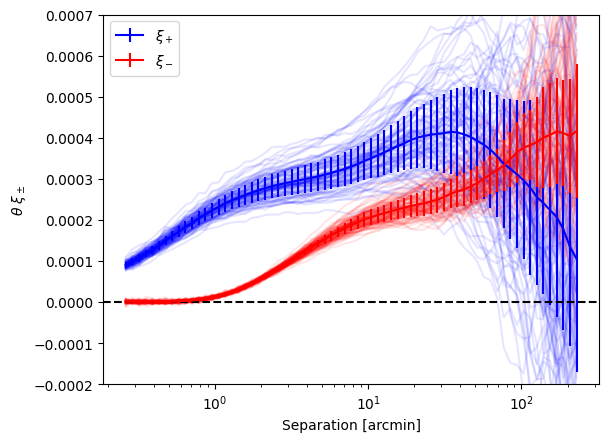

In [17]:
for elp in range(shapecat.npatches):
    plt.semilogx(centers_patches[elp,0],centers_patches[elp,0]*xip_patches[elp,0],color='blue',alpha=0.1)
    plt.semilogx(centers_patches[elp,0],centers_patches[elp,0]*xim_patches[elp,0],color='red',alpha=0.1)
plt.errorbar(x=twopcf.bin_centers_mean, 
             y=twopcf.bin_centers_mean*twopcf.xip[0],
             yerr=twopcf.bin_centers_mean*np.sqrt(xip_samplevar[0]),
             color='blue', label=r"$\xi_+$"
             )
plt.errorbar(x=twopcf.bin_centers_mean, 
             y=twopcf.bin_centers_mean*twopcf.xim[0],
             yerr=twopcf.bin_centers_mean*np.sqrt(xim_samplevar[0]),
             color='red', label=r"$\xi_-$")
plt.axhline(0, color='k', ls='--')
plt.ylim(-2e-4,7e-4)
plt.xlabel('Separation [arcmin]')
plt.ylabel(r'$\theta \ \xi_\pm$')
plt.legend()
plt.xscale('log')

## Do 3PCF computation on orpheus

For completeness, let us repeat the same business on at the 3pt-level.

### Initialise relevant classes

In [18]:
# General setup for 2pcf computation
min_sep = 0.25
max_sep = 240.
binsize = 0.1
nbinsphi = 100
nmaxs = 30
rmin_pixsize = 20
nthreads = 48

# Parametes we use for the decomposition of the catalog into patches
npatches = 100
patchextend_deg=4.

In [19]:
shapecat = orpheus.SpinTracerCatalog(
    spin=2,
    pos1=fskycat['ra'],
    pos2=fskycat['dec'],
    tracer_1=-fskycat['gamma1'],
    tracer_2=-fskycat['gamma2'],
    units_pos1='deg',
    units_pos2='deg',
    geometry='spherical'
)

In [20]:
shapecat.topatches(npatches=npatches, patchextend_deg=patchextend_deg)

In [21]:
threepcf = orpheus.GGGCorrelation(n_cfs=4,
                                  min_sep=min_sep, 
                                  max_sep=max_sep, 
                                  binsize=binsize,
                                  nbinsphi=nbinsphi,
                                  nmaxs=nmaxs,
                                  rmin_pixsize=rmin_pixsize,
                                  tree_resos=[0,1.,2.,4.],
                                  verbosity=1,
                                  nthreads=nthreads)

### Compute the 3pt statistics

In [22]:
%%time
threept_patches = threepcf.process(shapecat, keep_patchres=True)

Doing patch 1/100
Doing patch 2/100
Doing patch 3/100
Doing patch 4/100
Doing patch 5/100
Doing patch 6/100
Doing patch 7/100
Doing patch 8/100
Doing patch 9/100
Doing patch 10/100
Doing patch 11/100
Doing patch 12/100
Doing patch 13/100
Doing patch 14/100
Doing patch 15/100
Doing patch 16/100
Doing patch 17/100
Doing patch 18/100
Doing patch 19/100
Doing patch 20/100
Doing patch 21/100
Doing patch 22/100
Doing patch 23/100
Doing patch 24/100
Doing patch 25/100
Doing patch 26/100
Doing patch 27/100
Doing patch 28/100
Doing patch 29/100
Doing patch 30/100
Doing patch 31/100
Doing patch 32/100
Doing patch 33/100
Doing patch 34/100
Doing patch 35/100
Doing patch 36/100
Doing patch 37/100
Doing patch 38/100
Doing patch 39/100
Doing patch 40/100
Doing patch 41/100
Doing patch 42/100
Doing patch 43/100
Doing patch 44/100
Doing patch 45/100
Doing patch 46/100
Doing patch 47/100
Doing patch 48/100
Doing patch 49/100
Doing patch 50/100
Doing patch 51/100
Doing patch 52/100
Doing patch 53/100
Do

In a next step we'll use the patchwise outputs to compute Map3 for each patch individually

In [23]:
centersr_patches, npcf_multipoles_patches, npcf_multipoles_norm_patches = threept_patches

In [24]:
import sys
map3radii = np.geomspace(1,64,31)

# Compute Map3 of full 3pcf
fskymap3 = threepcf.computeMap3(radii=map3radii)

# Compute Map3 of patchwise 3pcfs
allmap3 = np.zeros((shapecat.npatches, *fskymap3.shape), dtype=fskymap3.dtype)
for elp in range(shapecat.npatches):
    sys.stdout.write('%i '%elp)
    _pinst = orpheus.GGGCorrelation(n_cfs=threepcf.n_cfs,
                                    min_sep=threepcf.min_sep, 
                                    max_sep=threepcf.max_sep,
                                    nbinsr=threepcf.nbinsr,
                                    nmaxs=threepcf.nmaxs,
                                    nbinsphi=threepcf.nbinsphi,
                                    nthreads=threepcf.nthreads)
    _pinst.nbinsz = threepcf.nbinsz
    _pinst.nzcombis = threepcf.nzcombis
    _pinst.projection = 'X'
    _pinst.bin_centers_mean = np.mean(centersr_patches[elp],axis=(0))
    _pinst.npcf_multipoles = npcf_multipoles_patches[elp]
    _pinst.npcf_multipoles_norm = npcf_multipoles_norm_patches[elp]
    _pmap3 = _pinst.computeMap3(radii=map3radii)
    allmap3[elp] += 1*_pmap3

0 1 2 3 4 5 6 7 8 9 10 

11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

Finally, let us proceed similar to the 2pt case and compute an estimate of the sample covariance from the patches and then plot the results. Due to the integrated nature of Map3 the choice of weights is not trivial -- we use the total number of triplet counts within each footprint. 

In [25]:
# Choose as effective weights the sum over the n===0 multipole
map3_effws = np.sum(npcf_multipoles_norm_patches[:,0], axis=(-1,-2)).real
_V1 = np.sum(map3_effws,axis=0)
_V2 = np.sum(map3_effws**2,axis=0)
map3_samplevar = np.sum(map3_effws*(allmap3-fskymap3)**2,axis=0)/(_V1-_V2/_V1**2)

/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/users/lporth/anaconda3/envs/orpheus_devel/lib/python3.12/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


(-5e-08, 2.5e-07)

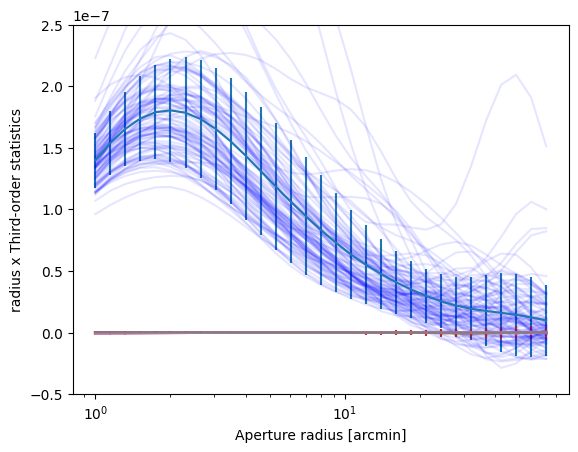

In [26]:
for elcomp in range(8):
    plt.errorbar(x=map3radii,
                 y=map3radii*fskymap3[elcomp,0],
                 yerr=map3radii*np.sqrt(map3_samplevar[elcomp,0]))
for elp in range(shapecat.npatches):
    plt.semilogx(map3radii, map3radii*allmap3[elp,0,0],color='blue',alpha=0.1)
plt.xlabel('Aperture radius [arcmin]')
plt.ylabel('radius x Third-order statistics')
plt.ylim(-.5e-7,2.5e-7)